In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd ~/code/sd_foregrounds/

/Data/abitbol/sd_foregrounds


In [3]:
import spectral_distortions as sd
import foregrounds as fg
import super_pixie

In [4]:
from scipy.optimize import minimize

In [5]:
from __future__ import unicode_literals

figsize(16, 10)
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

rcParams['lines.linewidth'] = 3
    
rcParams['xtick.labelsize'] = 30
rcParams['xtick.major.size'] = 10
rcParams['xtick.major.width'] = 1
rcParams['xtick.major.pad'] = 5
rcParams['xtick.minor.size'] = 5
rcParams['xtick.minor.width'] = 1
rcParams['xtick.bottom'] = True
rcParams['xtick.top'] = True
rcParams['xtick.direction'] = 'in'


rcParams['ytick.labelsize'] = 30
rcParams['ytick.major.size'] = 10
rcParams['ytick.major.width'] = 1
rcParams['ytick.major.pad'] = 5
rcParams['ytick.minor.size'] = 5
rcParams['ytick.minor.width'] = 1
rcParams['ytick.left'] = True
rcParams['ytick.right'] = True
rcParams['ytick.direction'] = 'in'


rcParams['legend.fontsize'] = 24
rcParams['legend.borderaxespad'] = 1

rcParams['axes.labelsize'] = 30
rcParams['axes.titlesize'] = 30

# Generate data

In [6]:
efn = 1./np.sqrt(10.)
mults = np.ones(3) #* efn

In [7]:
fncs=[sd.DeltaI_DeltaT, sd.DeltaI_mu, sd.DeltaI_reltSZ_2param_yweight, 
      fg.synch, fg.freefree, fg.thermal_dust, fg.cib, fg.spinning_dust, fg.co]

In [8]:
fish = super_pixie.FisherEstimation(mults=mults, fncs=fncs)
fish.run_fisher_calculation()
fish.print_errors()

DeltaT_amp 5573.2769142951065
mu_amp 0.38407494996752345
y_tot 266.96052669304714
kT_yweight 12.905668781802785
As 25.27959505054311
alps 75.179931283407
EM 44.35002015414082
Ad 757.4110481710983
Bd 2532.9843065102177
Td 25466.55800622708
Acib 286.3766071340068
Bcib 846.5473447969497
Tcib 4098.146886916134
Asd 1151.7852307523574
Aco 440.55316909523765


In [9]:
freqs = fish.frequencies

In [10]:
data = {}
for fnc in fish.signals:
    name = fnc.__name__
    data[name] = fnc(freqs)

In [11]:
total = np.zeros_like(freqs)
for k, y in data.iteritems():
    total += y

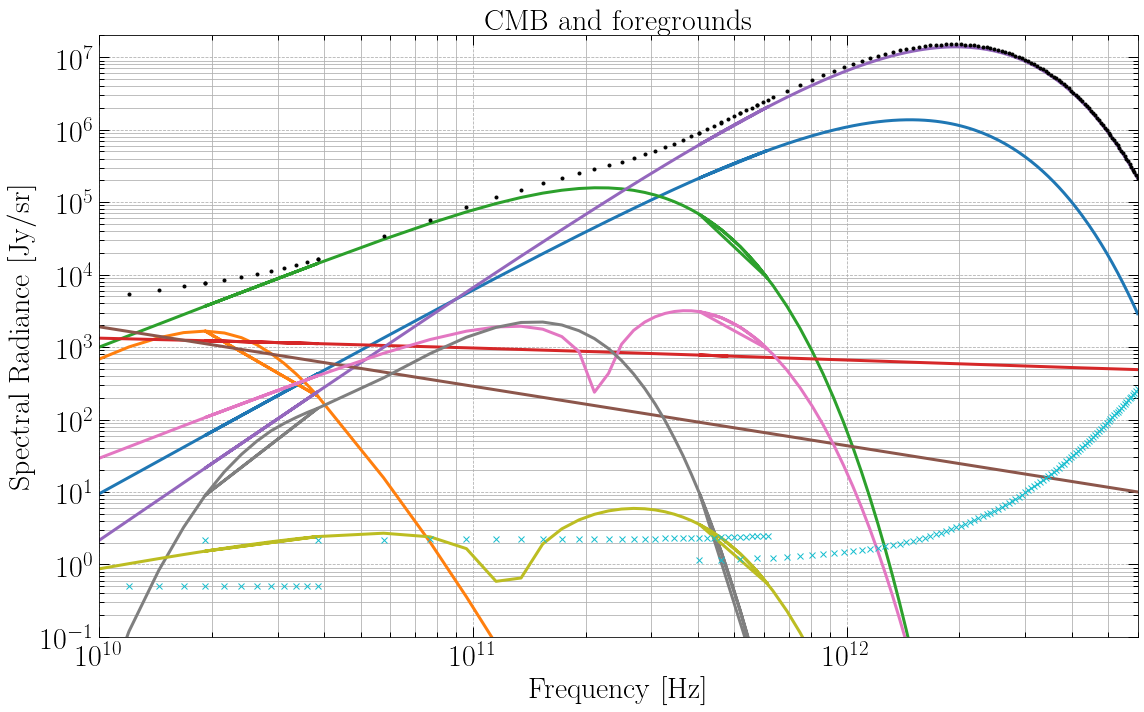

In [12]:
for x, y in data.iteritems():
    loglog(freqs, np.abs(y))
loglog(freqs, fish.noise, 'x')
loglog(freqs, total, 'k.')

grid(which='minor')
grid(ls='--')
ylabel('$\mathrm{Spectral\ Radiance\ [Jy/sr]}$')
xlabel('$\mathrm{Frequency\ [Hz]}$')
ylim(1e-1, 2e7)
xlim(1e10, 6e12)
title('$\mathrm{CMB\ and\ foregrounds}$')
tight_layout()

# make model

In [13]:
x = np.copy(fish.frequencies)
y = np.copy(total)
noise = np.copy(fish.noise)

In [14]:
fncs=[sd.DeltaI_DeltaT, sd.DeltaI_mu, sd.DeltaI_reltSZ_2param_yweight, 
      fg.synch_curv, fg.freefree, fg.thermal_dust, fg.cib, fg.spinning_dust, fg.co]

In [15]:
fish.args

array(['DeltaT_amp', 'mu_amp', 'y_tot', 'kT_yweight', 'As', 'alps', 'EM',
       'Ad', 'Bd', 'Td', 'Acib', 'Bcib', 'Tcib', 'Asd', 'Aco'],
      dtype='|S32')

In [16]:
def lnlike(theta):
    dt, muamp, ytot, kT, As, alps, EM, Ad, Bd, Td, Acib, Bcib, Tcib, Asd, Aco = theta
    model = sd.DeltaI_DeltaT(x, dt)
    model += sd.DeltaI_mu(x, muamp)
    model += sd.DeltaI_reltSZ_2param_yweight(x, ytot, kT)
    
    model += fg.synch(x, As, alps)
    model += fg.freefree(x, EM)
    model += fg.thermal_dust(x, Ad, Bd, Td)
    model += fg.cib(x, Acib, Bcib, Tcib)
    
    model += fg.spinning_dust(x, Asd)
    model += fg.co(x, Aco)
    return np.sum( (y-model)**2 / noise**2 )

In [30]:
bounds = [(-np.inf, np.inf), (-np.inf, np.inf), (-np.inf, np.inf), (0.1, 10), (0, np.inf), (-3, 0), 
          (0, np.inf), (0, np.inf), (0, 2), (10, 30), (0, np.inf), (0, 2), (10, 30), (0, np.inf), (0, np.inf)]

In [31]:
opt = minimize(lnlike, fish.p0, method="TNC", bounds=bounds)

In [33]:
opt.x - fish.p0

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# cut rSZ

In [34]:
fncs=[sd.DeltaI_DeltaT, sd.DeltaI_mu, sd.DeltaI_y, 
      fg.synch, fg.freefree, fg.thermal_dust, fg.cib, fg.spinning_dust, fg.co]

In [35]:
fish = super_pixie.FisherEstimation(mults=mults, fncs=fncs)

In [36]:
fish.args

array(['DeltaT_amp', 'mu_amp', 'y_tot', 'As', 'alps', 'EM', 'Ad', 'Bd',
       'Td', 'Acib', 'Bcib', 'Tcib', 'Asd', 'Aco'], dtype='|S32')

In [37]:
def lnlike(theta):
    dt, muamp, ytot, As, alps, EM, Ad, Bd, Td, Acib, Bcib, Tcib, Asd, Aco = theta
    model = sd.DeltaI_DeltaT(x, dt)
    model += sd.DeltaI_mu(x, muamp)
    model += sd.DeltaI_y(x, ytot)
    
    model += fg.synch(x, As, alps)
    model += fg.freefree(x, EM)
    model += fg.thermal_dust(x, Ad, Bd, Td)
    model += fg.cib(x, Acib, Bcib, Tcib)
    
    model += fg.spinning_dust(x, Asd)
    model += fg.co(x, Aco)
    return np.sum( (y-model)**2 / noise**2 )

In [38]:
bounds = [(-np.inf, np.inf), (-np.inf, np.inf), (-np.inf, np.inf), (0, np.inf), (-3, 0), 
          (0, np.inf), (0, np.inf), (0, 2), (10, 30), (0, np.inf), (0, 2), (10, 30), (0, np.inf), (0, np.inf)]

In [39]:
opt = minimize(lnlike, fish.p0, method="TNC", bounds=bounds)

In [40]:
fish.p0

array([ 1.20e-04,  2.00e-08,  1.77e-06,  2.88e+02, -8.20e-01,  3.00e+02,
        1.36e+06,  1.53e+00,  2.10e+01,  3.46e+05,  8.60e-01,  1.88e+01,
        1.00e+00,  1.00e+00])

In [44]:
opt.x

array([ 1.19981371e-04,  2.40516243e-09,  1.76189322e-06,  2.88000000e+02,
       -8.20000000e-01,  3.00000000e+02,  1.36000000e+06,  1.53000000e+00,
        2.09999999e+01,  3.46000000e+05,  8.60000001e-01,  1.88000000e+01,
        1.00000000e+00,  1.00000000e+00])

In [42]:
(opt.x - fish.p0)/fish.p0

array([-1.55239823e-04, -8.79741878e-01, -4.58010352e-03,  1.08752513e-13,
       -5.37645809e-13,  6.94437100e-13,  1.99280587e-09,  2.27701068e-09,
       -4.51948641e-09,  4.58075954e-10,  1.13701129e-09, -9.06881756e-10,
        1.28341782e-13,  6.57252031e-13])

In [43]:
redchi = opt.fun / (len(freqs) - len(fish.args))
print redchi

95.99308270343675596


# cut ame

In [45]:
fncs=[sd.DeltaI_DeltaT, sd.DeltaI_mu, sd.DeltaI_reltSZ_2param_yweight, 
      fg.synch, fg.freefree, fg.thermal_dust, fg.cib, fg.co]

In [46]:
fish = super_pixie.FisherEstimation(mults=mults, fncs=fncs)

In [47]:
fish.args

array(['DeltaT_amp', 'mu_amp', 'y_tot', 'kT_yweight', 'As', 'alps', 'EM',
       'Ad', 'Bd', 'Td', 'Acib', 'Bcib', 'Tcib', 'Aco'], dtype='|S32')

In [48]:
def lnlike(theta):
    dt, muamp, ytot, kT, As, alps, EM, Ad, Bd, Td, Acib, Bcib, Tcib, Aco = theta
    model = sd.DeltaI_DeltaT(x, dt)
    model += sd.DeltaI_mu(x, muamp)
    model += sd.DeltaI_reltSZ_2param_yweight(x, ytot, kT)
    
    model += fg.synch(x, As, alps)
    model += fg.freefree(x, EM)
    model += fg.thermal_dust(x, Ad, Bd, Td)
    model += fg.cib(x, Acib, Bcib, Tcib)
    
    #model += fg.spinning_dust(x, Asd)
    model += fg.co(x, Aco)
    return np.sum( (y-model)**2 / noise**2 )

In [49]:
bounds = [(-np.inf, np.inf), (-np.inf, np.inf), (-np.inf, np.inf), (0.1, 10), (0, np.inf), (-3, 0), 
          (0, np.inf), (0, np.inf), (0, 2), (10, 30), (0, np.inf), (0, 2), (10, 30), (0, np.inf)]

In [50]:
opt = minimize(lnlike, fish.p0, method="TNC", bounds=bounds)

In [57]:
opt = minimize(lnlike, fish.p0)

In [58]:
fish.p0

array([ 1.200e-04,  2.000e-08,  1.770e-06,  1.245e+00,  2.880e+02,
       -8.200e-01,  3.000e+02,  1.360e+06,  1.530e+00,  2.100e+01,
        3.460e+05,  8.600e-01,  1.880e+01,  1.000e+00])

In [59]:
opt.x

array([ 1.20470918e-04, -6.14687940e-07,  1.32257450e-06,  1.88684389e+00,
        3.04463344e+02, -1.00745430e+00,  2.97198343e+02,  1.35999995e+06,
        1.53029139e+00,  2.09974531e+01,  3.46000003e+05,  8.56860162e-01,
        1.87991583e+01,  7.30457375e-01])

In [60]:
(opt.x - fish.p0)/fish.p0

array([ 3.92431920e-03, -3.17343970e+01, -2.52782770e-01,  5.15537262e-01,
        5.71643874e-02,  2.28602802e-01, -9.33885681e-03, -3.69589320e-08,
        1.90448412e-04, -1.21278948e-04,  9.75130400e-09, -3.65097427e-03,
       -4.47726839e-05, -2.69542625e-01])

In [61]:
redchi = opt.fun / (len(freqs) - len(fish.args))
print redchi

169431.677013


# cut CO

In [62]:
fncs=[sd.DeltaI_DeltaT, sd.DeltaI_mu, sd.DeltaI_reltSZ_2param_yweight, 
      fg.synch, fg.freefree, fg.thermal_dust, fg.cib, fg.spinning_dust]

In [63]:
fish = super_pixie.FisherEstimation(mults=mults, fncs=fncs)

In [64]:
fish.args

array(['DeltaT_amp', 'mu_amp', 'y_tot', 'kT_yweight', 'As', 'alps', 'EM',
       'Ad', 'Bd', 'Td', 'Acib', 'Bcib', 'Tcib', 'Asd'], dtype='|S32')

In [65]:
def lnlike(theta):
    dt, muamp, ytot, kT, As, alps, EM, Ad, Bd, Td, Acib, Bcib, Tcib, Asd = theta
    model = sd.DeltaI_DeltaT(x, dt)
    model += sd.DeltaI_mu(x, muamp)
    model += sd.DeltaI_reltSZ_2param_yweight(x, ytot, kT)
    
    model += fg.synch(x, As, alps)
    model += fg.freefree(x, EM)
    model += fg.thermal_dust(x, Ad, Bd, Td)
    model += fg.cib(x, Acib, Bcib, Tcib)
    
    model += fg.spinning_dust(x, Asd)
    #model += fg.co(x, Aco)
    return np.sum( (y-model)**2 / noise**2 )

In [71]:
opt = minimize(lnlike, fish.p0)

In [72]:
fish.p0

array([ 1.200e-04,  2.000e-08,  1.770e-06,  1.245e+00,  2.880e+02,
       -8.200e-01,  3.000e+02,  1.360e+06,  1.530e+00,  2.100e+01,
        3.460e+05,  8.600e-01,  1.880e+01,  1.000e+00])

In [73]:
opt.x

array([ 1.21103465e-04,  1.97790660e-07,  1.31678975e-06,  2.09721171e+00,
        2.80982735e+02, -8.36976075e-01,  2.91083906e+02,  1.35999915e+06,
        1.53008023e+00,  2.09994242e+01,  3.46000525e+05,  8.59184016e-01,
        1.87989888e+01,  1.00422911e+00])

In [74]:
(opt.x - fish.p0)/fish.p0

array([ 9.19554015e-03,  8.88953301e+00, -2.56050986e-01,  6.84507396e-01,
       -2.43655021e-02,  2.07025303e-02, -2.97203129e-02, -6.25801288e-07,
        5.24349528e-05, -2.74195994e-05,  1.51602840e-06, -9.48818488e-04,
       -5.37893476e-05,  4.22910962e-03])

In [75]:
redchi = opt.fun / (len(freqs) - len(fish.args))
print redchi

4733.67063343
